# Project 1 Numerical Analysis
Principle component analysis on  multispectral imagery of earth

Cole Persch Jackson Krebsbach Cedric Porter


In [1]:
import dispCropIm
import dispPCAIm
import numpy as np
import householder
import random
import geopandas as gp
import pandas as pd
import rasterio
from matplotlib import pyplot as plt
import fiona

### Plotting RGB and NIR Values

The region of interest will cropped and displayed by the following code using the module disCropIm.py created by Dr. Brian Yurk.

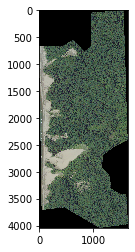

In [2]:
infile = './m_4208623_nw_16_060_20180707/m_4208623_nw_16_060_20180707.tif'
shapefile = './HopePreserveGMB/HopePreserveGMB.shp'
r = 0
g = 1
b = 
no_data = 0
outfile = './outCropMask.tif'

Z = dispCropIm.dispCropIm(infile,shapefile,r,g,b,no_data,outfile)

The cropped image is transformed using the module disCropIm and 12 scatter plots are created of pairs of bands (ex red and green or nir and blue) with the following code.

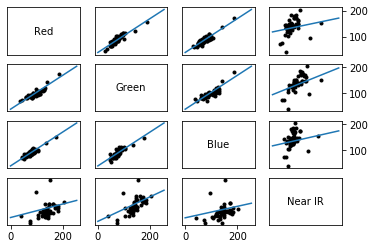

Slopes of the linear fits
[[1.         0.88540403 0.76492059 0.2077092 ]
 [0.99751595 1.         0.77905749 0.40127118]
 [1.18207253 1.06860924 1.         0.22487502]
 [0.24935114 0.42757791 0.17469042 1.        ]]
Intercepts of the linear fits
[[  0.          27.10379461  20.95935025 118.4460494 ]
 [-17.4950579    0.           5.98237369  95.51393616]
 [-16.94856028  10.26181998   0.         116.64907809]
 [ 47.92762757  41.5351967   59.79268924   0.        ]]


In [3]:
randPix = np.empty([50, 4]) # Create array to hold 50 random pixels

for num in range(0,50): # Select 50 random pixels from image
    zRows = np.size(Z,0)
    randRow = np.random.randint(0,zRows)
    randPix[num,:] = Z[randRow,:]
    num += 1

imName = ["Red", "Green", "Blue", "Near IR"] # Create list of band names for plot
imVals = [[randPix[:,0]], [randPix[:,1]], [randPix[:,2]], [randPix[:,3]]] # Create array of bands for plot creation

aMatrix = np.empty([5185371, 2]) # Matrix for use in householder triangularization
aMatrix[:,0] = 1 # Set first columns to ones for linear fit

intercept = np.zeros([4,4]) # Matrix to store intercept data
slope = np.ones([4,4]) # Matrix to store slope data

fig,scatter =  plt.subplots(4,4) # Create plot with 4x4 grid of subplots
#fig.suptitle("Scatter Plots for Each Red, Green, Blue, and Near IR Band Pair", fontsize=12) # Plot title

for row in range(0,4): # Iterate through the plot
    
    for col in range(0,4):
        
        scatter[row,col].tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False) # Turn off all axis ticks and labels
        
        if row == col:
            
            scatter[row,col].text(0.5, 0.5, imName[row], horizontalalignment='center',verticalalignment='center') # Place band names on leading diagonal plots
            
        else:
            
            aMatrix[:,1] = Z[:,row] # Build the A matrix for householder
            bVector = Z[:,col] # Build the b vector for householder
            xResult = householder.houseTriang(aMatrix,bVector) # Perform householder triangularization
            
            intercept[row,col] = xResult[4][0] # Store householder intercept data 
            slope[row,col] = xResult[4][1] # Store householder slope data
            
            scatter[row,col].plot(imVals[row],imVals[col], marker = '.',color = 'black')
            #scatter[row,col].scatter(imVals[row],imVals[col]) # Plot scatter plot of band pairs
            
            xVals = np.arange(0, 255, 1) # Grid of 1 spacing from 0 to 255
            yVals = 0 # Initialize the y values to 0
    
            for i in range(0, len(xResult[4])): # For i in range of the length of the householder results
                yVals += xResult[4][i]*(xVals**i) # Go through all xVals and xReults to form y values
    
            scatter[row,col].plot(xVals, yVals) # Plot x and y values
            
            if row == 3: # Add appropirate tick marks to plot
                scatter[row,col].tick_params(which='both', bottom=True, left=False, labelbottom=True, labelleft=False)
            elif col == 3:
                scatter[row,col].tick_params(which='both', bottom=False, left=False, right=True, labelbottom=False, labelleft=False, labelright=True)

plt.show()
print("Slopes of the linear fits")
print(slope)
print("Intercepts of the linear fits")
print(intercept)

In [4]:
#Saves the resulting scatter plot
fig.savefig('Scatter.png', dpi = 300)

### Covariance and Correlation Matrices for RGB cropped image:
Before the principle components analysis is done the matrix Z must be centered. This is done by subtracting out the column means from the matrix. Next, the PCA analysis is done.

In [5]:
m = np.size(Z,0) #Number of Rows
ZT = Z.transpose() #Transpose of Z
ones = np.ones((m,1)) #Ones Vector
Z_Mean = (1/m)*(np.matmul(ZT,ones)) #Mean of Z
ZMT = Z_Mean.transpose() #Transpose of the mean of Z
G = np.subtract(Z, np.matmul(ones,ZMT)) #G_Centered Matrix by subtracting out the means.

The following code calculates the covariance and then is normalized resulting in the correlation matrix between the four bands.

In [6]:
#Co-Variance Matrix

GT = G.transpose()
s = (1/(m-1))*np.matmul(GT,G)
print('Co-Variance Matrix')
print(s)
print("")

d =np.zeros((4,4))
for i in range(0,len(s)):
    d[i,i] = (s[i,i])**(-1/2)

    
#Sample Correlation Matrix
r_hat = np.matmul(d,s)
r=np.matmul(r_hat,d)
print('Correlation Matrix')
print(r)

Co-Variance Matrix
[[1535.15913083 1359.23607466 1174.27482436  318.86666803]
 [1359.23607466 1362.62089515 1061.56001116  546.78050017]
 [1174.27482436 1061.56001116  993.40335929  223.39160284]
 [ 318.86666803  546.78050017  223.39160284 1278.78566285]]

Correlation Matrix
[[1.         0.93978968 0.95088991 0.22757971]
 [0.93978968 1.         0.91241878 0.41421576]
 [0.95088991 0.91241878 1.         0.19820069]
 [0.22757971 0.41421576 0.19820069 1.        ]]


The PCA analysis is done. The eigen vectors are found using the eigh module. The columns in the matrix y correspond to the principle components.

In [7]:
[L,EV] = np.linalg.eigh(s)
V = EV[:,::-1]
Y = np.matmul(G,V)

Theh following plots the ROI in false color RGB with PC1, PC2, and PC3.

/Users/jackkrebsbach/.conda/envs/numa/lib/python3.7/site-packages/rasterio/mask.py:83: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  out_image = raster.read(window=window, masked=True)


Principal components have been rescaled to 1:255
Minimum value before rescaling: -279.6949415751087
Maximum value before rescaling: 154.29529451730673


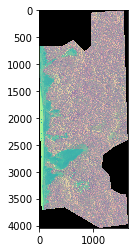

In [8]:
r = 0
g = 1
b = 2
PrincComp = Y
infile =  outfile
outfile = './outPCA.tif'

dispPCAIm.dispPCAIm(PrincComp,infile,shapefile,r,g,b,no_data,outfile)

### Covariance and Correlation matrix for the PCA false color image

Using the given modules we take the PCA image and find the co-variance and correlation matrices. 

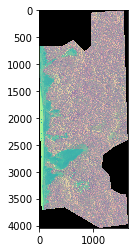

In [9]:
infile = './outPCA.tif'
shapefile = './HopePreserveGMB/HopePreserveGMB.shp'
outfile = './outPCA.tif'
r = 0
g = 1
b = 2
no_data = 0

Z = dispCropIm.dispCropIm(infile,shapefile,r,g,b,no_data,outfile)

Finding correlation co-variance matrices of the PCA output. 

In [10]:
m = np.size(Z,0) #Number of Rows
ZT = Z.transpose() #Transpose of Z
ones = np.ones((m,1)) #Ones Vector
Z_Mean = (1/m)*(np.matmul(ZT,ones)) #Mean of Z
ZMT = Z_Mean.transpose() #Transpose of the mean of Z
G = np.subtract(Z, np.matmul(ones,ZMT)) #G_Centered Matrix

In [11]:
# Sample Covariance Matrix

GT = G.transpose()
s = (1/(m-1))*np.matmul(GT,G)
print("PCA Co-variance")
print(s)
print("")

d =np.zeros((4,4))
for i in range(0,len(s)):
    d[i,i] = (s[i,i])**(-1/2)

    
#Sample Correlation Matrix
r_hat = np.matmul(d,s)
r=np.matmul(r_hat,d)
print('PCA Correlation Matrix')
print(r)

PCA Co-variance
[[ 1.33027264e+03  2.31012966e-03 -1.38186570e-03 -8.35280238e-03]
 [ 2.31012966e-03  3.98836624e+02  2.83740068e-03 -1.45023679e-03]
 [-1.38186570e-03  2.83740068e-03  2.39747686e+01 -9.73572365e-04]
 [-8.35280238e-03 -1.45023679e-03 -9.73572365e-04  1.81376366e+01]]

PCA Correlation Matrix
[[ 1.00000000e+00  3.17152771e-06 -7.73781415e-06 -5.37738992e-05]
 [ 3.17152771e-06  1.00000000e+00  2.90165611e-05 -1.70510471e-05]
 [-7.73781415e-06  2.90165611e-05  1.00000000e+00 -4.66875063e-05]
 [-5.37738992e-05 -1.70510471e-05 -4.66875063e-05  1.00000000e+00]]


### Comparing Red and Green with PC1 and PC2

After drawing polygons and assigning classes using QGIS the data can be extracted with the module 'fiona' and put into a CSV file. 

In [12]:
#Polygon File
with fiona.open('./GIS/GMBPOLY.shp') as shp:
    size = 1
    for t in shp:
        size += len(t['geometry']['coordinates'][0])
    
    df = pd.DataFrame(columns = ['X','Y','Red','Green','Blue','PC1','PC2','PC3','Class'],\
                  index =[np.arange(1,size)])    
    number = 0
    for feature in shp:
        
        coords = feature['geometry']['coordinates'][0]
        station_name = feature['properties']['Class']

        for x in coords:
            coord = x
            number += 1
            with rasterio.open('outCropMask.tif') as src:
                [Red,Green,Blue]= [v for v in src.sample([coord])][0][0:3]
            
            with rasterio.open('outPCA.tif') as src:
                [PC1,PC2,PC3]= [v for v in src.sample([coord])][0][0:3]
        
            df['Class'][number] = station_name
            df['X'][number] = coord[0]
            df['Y'][number] = coord[1]
            df['Red'][number] = Red
            df['Green'][number] = Green
            df['Blue'][number] = Blue
            df['PC1'][number]= PC1
            df['PC2'][number]= PC2
            df['PC3'][number]= PC3

df.to_csv('Ploygon_Data.csv', sep=',', encoding='utf-8')

In [13]:
data = pd.read_csv('Ploygon_Data.csv')

Creating the scatter plot of red and green values:

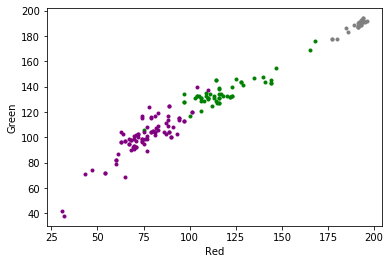

In [14]:
#Red color space values verse Green color space values

RS = data['Red'][data.Class == 'sand']
RD = data['Red'][data.Class == 'GCSD']
RF = data['Red'][data.Class == 'IFC']


GS = data['Green'][data.Class == 'sand']
GD = data['Green'][data.Class == 'GCSD']
GF = data['Green'][data.Class == 'IFC']


fig,ax = plt.subplots()
ax.plot(RS[:],GS[:],'ro',color ='grey', marker = '.')
ax.plot(RD[:],GD[:], 'ro', color = 'green',  marker = '.')
ax.plot(RF[:],GF[:],'ro', color = 'purple',  marker = '.')
#plt.title("Red and Green Values", fontsize = 20)

ax.set(xlabel = 'Red', ylabel = 'Green')
fig.savefig('Red_Green.png', dpi = 300)

Creating the scatter plot of PC1 and PC2 values.

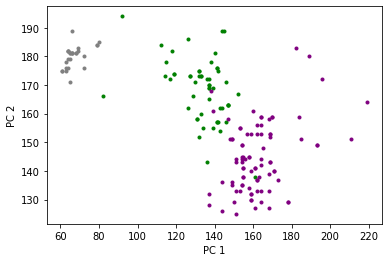

In [15]:
SPC1 = data['PC1'][data.Class == 'sand']
GPC1 = data['PC1'][data.Class == 'GCSD']
FPC1 =  data['PC1'][data.Class == 'IFC']


SPC2 = data['PC2'][data.Class == 'sand']
GPC2 = data['PC2'][data.Class == 'GCSD']
FPC2 = data['PC2'][data.Class == 'IFC']

fig,ax = plt.subplots()

ax.plot(SPC1[:],SPC2[:],'ro',color ='grey', marker = '.')
ax.plot(GPC1[:],GPC2[:], 'ro', color = 'green', marker = '.')
ax.plot(FPC1[:],FPC2[:],'ro', color = 'purple', marker = '.')

#plt.title("Principle Components 1 & 2", fontsize = 20)

ax.set(xlabel = 'PC 1', ylabel = 'PC 2')
fig.savefig('PC1_PC2.png', dpi = 300)